In [1]:
import sys
sys.path.append("../../")

import bayesflow as bf
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from bayesflow.experimental.rectifiers import RectifiedDistribution
from summary import CustomSummary
from amortizers import ConsistencyAmortizer, ConfigurableMLP, DriftNetwork

2023-12-05 11:41:13.396533: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-05 11:41:13.418685: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-05 11:41:13.748661: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/radevs/anaconda3/envs/BayesFlowDev/lib/python3.10/site-packages/bayesflow/trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonot

## Data Loading and Configuration

In [2]:
def read_offline_data(obs_path, param_path, validation_ratio: float = 0.02):
    assert(len(obs_path) == len(param_path))
    observables = []
    params = []
    for i in range(len(obs_path)):
        observables.append(pd.read_pickle(obs_path[i]))
        params.append(pd.read_pickle(param_path[i]))
    obs = np.stack(pd.concat(observables).to_numpy())
    tumor_size = np.stack(obs[:,0])[:, :, None].astype(np.float32)
    radial_features = np.stack([np.stack(obs[:,1]),np.stack(obs[:,2])], axis=-1)[:,:300,:].astype(np.float32)
    params = pd.concat(params).to_numpy().astype(np.float32)
    split = int(validation_ratio * params.shape[0])
    train = {"prior_draws": params[split:], 
             "sim_data": radial_features[split:], 
             'growth_curve': tumor_size[split:]}
    validation = {"prior_draws": params[:split], 
                  "sim_data": radial_features[:split], 
                  'growth_curve': tumor_size[:split]}    
    return train, validation

In [3]:
def configure_input(forward_dict):
    """Custom configurator."""
    
    out_dict = {}
    pp_ecmp = (forward_dict['sim_data'] - MEAN_SIM) / STD_SIM
    pp_ecmp = np.c_[pp_ecmp, [POSITIONAL_EMBEDDINGS]*pp_ecmp.shape[0]]
    growth =  (forward_dict['growth_curve'] - MEAN_GROWTH) / STD_GROWTH 
    params = forward_dict['prior_draws']
    
    out_dict = {
        'summary_conditions': (pp_ecmp, growth),
        'parameters': params
    }    
    return out_dict

In [4]:
train_data, val_data = read_offline_data(
    obs_path=['../../tumor_data/observables_10000_1.pkl', '../../tumor_data/observables_10000_2.pkl'],
    param_path=['../../tumor_data/params_10000_1.pkl', '../../tumor_data/params_10000_2.pkl']
)

In [5]:
MEAN_GROWTH = train_data['growth_curve'].mean((0, 1))
STD_GROWTH = train_data['growth_curve'].std((0, 1))
MEAN_SIM = train_data['sim_data'].mean((0, 1))
STD_SIM = train_data['sim_data'].std((0, 1))

## Networks

In [6]:
BATCH_SIZE = 64
EPOCHS = 1000
POSITIONAL_EMBEDDINGS = np.linspace(0, 1, train_data['sim_data'].shape[1], dtype=np.float32)[:, None]

In [7]:
ITERATIONS = int(np.ceil((train_data['sim_data'].shape[0] / BATCH_SIZE))*EPOCHS)

In [9]:
summary_net = CustomSummary()

inference_net = ConfigurableMLP(
    input_dim=train_data['prior_draws'].shape[-1],
    condition_dim=32,
    hidden_dim=512,
    num_hidden=4,
    dropout_rate=0.2,
)

amortizer = ConsistencyAmortizer(
    consistency_net=inference_net, 
    num_steps=ITERATIONS, 
    summary_net=summary_net,
    sigma2=tf.math.reduce_variance(train_data['prior_draws'], axis=0, keepdims=True),
    T_max=200
)

2023-12-05 12:04:16.410504: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-05 12:04:16.426277: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-05 12:04:16.426381: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## Consistency Trainer

In [10]:
trainer = bf.trainers.Trainer(
    amortizer=amortizer,
    configurator=configure_input,
    checkpoint_path='ckpt/cm1k_T200',
)

INFO:root:Trainer initialization: No generative model provided. Only offline learning mode is available!
INFO:root:Initialized empty loss history.
INFO:root:Initialized networks from scratch.


In [11]:
h = trainer.train_offline(
    train_data, 
    epochs=EPOCHS,
    batch_size=BATCH_SIZE, 
    validation_sims=val_data
)

Training epoch 1:   0%|          | 0/307 [00:00<?, ?it/s]

2023-12-05 12:04:27.948115: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-12-05 12:04:27.964500: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-12-05 12:04:28.102003: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f0a2c97ad20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-05 12:04:28.102023: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A2000 12GB, Compute Capability 8.6
2023-12-05 12:04:28.104505: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-05 12:04:28.170359: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the pro

Training epoch 2:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 2, Loss: 0.471


Training epoch 3:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 3, Loss: 0.489


Training epoch 4:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 4, Loss: 0.485


Training epoch 5:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 5, Loss: 0.497


Training epoch 6:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 6, Loss: 0.452


Training epoch 7:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 7, Loss: 0.468


Training epoch 8:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 8, Loss: 0.479


Training epoch 9:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 9, Loss: 0.453


Training epoch 10:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 10, Loss: 0.447


Training epoch 11:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 11, Loss: 0.437


Training epoch 12:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 12, Loss: 0.431


Training epoch 13:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 13, Loss: 0.438


Training epoch 14:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 14, Loss: 0.442


Training epoch 15:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 15, Loss: 0.453


Training epoch 16:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 16, Loss: 0.434


Training epoch 17:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 17, Loss: 0.424


Training epoch 18:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 18, Loss: 0.453


Training epoch 19:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 19, Loss: 0.441


Training epoch 20:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 20, Loss: 0.440


Training epoch 21:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 21, Loss: 0.433


Training epoch 22:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 22, Loss: 0.436


Training epoch 23:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 23, Loss: 0.447


Training epoch 24:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 24, Loss: 0.461


Training epoch 25:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 25, Loss: 0.442


Training epoch 26:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 26, Loss: 0.438


Training epoch 27:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 27, Loss: 0.447


Training epoch 28:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 28, Loss: 0.440


Training epoch 29:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 29, Loss: 0.423


Training epoch 30:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 30, Loss: 0.415


Training epoch 31:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 31, Loss: 0.417


Training epoch 32:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 32, Loss: 0.425


Training epoch 33:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 33, Loss: 0.424


Training epoch 34:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 34, Loss: 0.413


Training epoch 35:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 35, Loss: 0.419


Training epoch 36:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 36, Loss: 0.424


Training epoch 37:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 37, Loss: 0.433


Training epoch 38:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 38, Loss: 0.423


Training epoch 39:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 39, Loss: 0.422


Training epoch 40:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 40, Loss: 0.409


Training epoch 41:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 41, Loss: 0.421


Training epoch 42:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 42, Loss: 0.414


Training epoch 43:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 43, Loss: 0.406


Training epoch 44:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 44, Loss: 0.436


Training epoch 45:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 45, Loss: 0.408


Training epoch 46:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 46, Loss: 0.436


Training epoch 47:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 47, Loss: 0.440


Training epoch 48:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 48, Loss: 0.439


Training epoch 49:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 49, Loss: 0.399


Training epoch 50:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 50, Loss: 0.424


Training epoch 51:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 51, Loss: 0.428


Training epoch 52:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 52, Loss: 0.398


Training epoch 53:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 53, Loss: 0.411


Training epoch 54:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 54, Loss: 0.415


Training epoch 55:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 55, Loss: 0.420


Training epoch 56:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 56, Loss: 0.422


Training epoch 57:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 57, Loss: 0.428


Training epoch 58:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 58, Loss: 0.406


Training epoch 59:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 59, Loss: 0.419


Training epoch 60:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 60, Loss: 0.391


Training epoch 61:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 61, Loss: 0.422


Training epoch 62:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 62, Loss: 0.424


Training epoch 63:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 63, Loss: 0.437


Training epoch 64:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 64, Loss: 0.399


Training epoch 65:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 65, Loss: 0.395


Training epoch 66:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 66, Loss: 0.409


Training epoch 67:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 67, Loss: 0.401


Training epoch 68:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 68, Loss: 0.412


Training epoch 69:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 69, Loss: 0.423


Training epoch 70:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 70, Loss: 0.406


Training epoch 71:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 71, Loss: 0.418


Training epoch 72:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 72, Loss: 0.411


Training epoch 73:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 73, Loss: 0.395


Training epoch 74:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 74, Loss: 0.413


Training epoch 75:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 75, Loss: 0.405


Training epoch 76:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 76, Loss: 0.396


Training epoch 77:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 77, Loss: 0.382


Training epoch 78:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 78, Loss: 0.394


Training epoch 79:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 79, Loss: 0.393


Training epoch 80:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 80, Loss: 0.413


Training epoch 81:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 81, Loss: 0.396


Training epoch 82:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 82, Loss: 0.425


Training epoch 83:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 83, Loss: 0.401


Training epoch 84:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 84, Loss: 0.411


Training epoch 85:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 85, Loss: 0.413


Training epoch 86:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 86, Loss: 0.393


Training epoch 87:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 87, Loss: 0.389


Training epoch 88:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 88, Loss: 0.398


Training epoch 89:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 89, Loss: 0.386


Training epoch 90:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 90, Loss: 0.419


Training epoch 91:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 91, Loss: 0.386


Training epoch 92:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 92, Loss: 0.373


Training epoch 93:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 93, Loss: 0.426


Training epoch 94:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 94, Loss: 0.388


Training epoch 95:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 95, Loss: 0.404


Training epoch 96:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 96, Loss: 0.391


Training epoch 97:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 97, Loss: 0.411


Training epoch 98:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 98, Loss: 0.407


Training epoch 99:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 99, Loss: 0.423


Training epoch 100:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 100, Loss: 0.363


Training epoch 101:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 101, Loss: 0.407


Training epoch 102:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 102, Loss: 0.402


Training epoch 103:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 103, Loss: 0.411


Training epoch 104:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 104, Loss: 0.413


Training epoch 105:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 105, Loss: 0.397


Training epoch 106:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 106, Loss: 0.427


Training epoch 107:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 107, Loss: 0.399


Training epoch 108:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 108, Loss: 0.416


Training epoch 109:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 109, Loss: 0.409


Training epoch 110:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 110, Loss: 0.418


Training epoch 111:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 111, Loss: 0.399


Training epoch 112:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 112, Loss: 0.401


Training epoch 113:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 113, Loss: 0.411


Training epoch 114:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 114, Loss: 0.414


Training epoch 115:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 115, Loss: 0.391


Training epoch 116:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 116, Loss: 0.429


Training epoch 117:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 117, Loss: 0.396


Training epoch 118:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 118, Loss: 0.397


Training epoch 119:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 119, Loss: 0.380


Training epoch 120:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 120, Loss: 0.374


Training epoch 121:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 121, Loss: 0.393


Training epoch 122:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 122, Loss: 0.392


Training epoch 123:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 123, Loss: 0.390


Training epoch 124:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 124, Loss: 0.390


Training epoch 125:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 125, Loss: 0.399


Training epoch 126:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 126, Loss: 0.394


Training epoch 127:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 127, Loss: 0.385


Training epoch 128:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 128, Loss: 0.397


Training epoch 129:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 129, Loss: 0.388


Training epoch 130:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 130, Loss: 0.413


Training epoch 131:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 131, Loss: 0.401


Training epoch 132:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 132, Loss: 0.375


Training epoch 133:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 133, Loss: 0.416


Training epoch 134:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 134, Loss: 0.400


Training epoch 135:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 135, Loss: 0.358


Training epoch 136:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 136, Loss: 0.416


Training epoch 137:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 137, Loss: 0.395


Training epoch 138:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 138, Loss: 0.395


Training epoch 139:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 139, Loss: 0.392


Training epoch 140:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 140, Loss: 0.402


Training epoch 141:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 141, Loss: 0.409


Training epoch 142:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 142, Loss: 0.397


Training epoch 143:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 143, Loss: 0.388


Training epoch 144:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 144, Loss: 0.372


Training epoch 145:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 145, Loss: 0.398


Training epoch 146:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 146, Loss: 0.389


Training epoch 147:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 147, Loss: 0.368


Training epoch 148:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 148, Loss: 0.393


Training epoch 149:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 149, Loss: 0.386


Training epoch 150:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 150, Loss: 0.395


Training epoch 151:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 151, Loss: 0.403


Training epoch 152:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 152, Loss: 0.376


Training epoch 153:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 153, Loss: 0.387


Training epoch 154:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 154, Loss: 0.393


Training epoch 155:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 155, Loss: 0.414


Training epoch 156:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 156, Loss: 0.360


Training epoch 157:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 157, Loss: 0.389


Training epoch 158:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 158, Loss: 0.398


Training epoch 159:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 159, Loss: 0.390


Training epoch 160:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 160, Loss: 0.394


Training epoch 161:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 161, Loss: 0.382


Training epoch 162:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 162, Loss: 0.390


Training epoch 163:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 163, Loss: 0.381


Training epoch 164:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 164, Loss: 0.360


Training epoch 165:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 165, Loss: 0.379


Training epoch 166:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 166, Loss: 0.383


Training epoch 167:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 167, Loss: 0.365


Training epoch 168:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 168, Loss: 0.393


Training epoch 169:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 169, Loss: 0.363


Training epoch 170:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 170, Loss: 0.377


Training epoch 171:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 171, Loss: 0.385


Training epoch 172:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 172, Loss: 0.375


Training epoch 173:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 173, Loss: 0.390


Training epoch 174:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 174, Loss: 0.385


Training epoch 175:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 175, Loss: 0.409


Training epoch 176:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 176, Loss: 0.369


Training epoch 177:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 177, Loss: 0.389


Training epoch 178:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 178, Loss: 0.375


Training epoch 179:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 179, Loss: 0.374


Training epoch 180:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 180, Loss: 0.387


Training epoch 181:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 181, Loss: 0.396


Training epoch 182:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 182, Loss: 0.399


Training epoch 183:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 183, Loss: 0.388


Training epoch 184:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 184, Loss: 0.389


Training epoch 185:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 185, Loss: 0.422


Training epoch 186:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 186, Loss: 0.382


Training epoch 187:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 187, Loss: 0.377


Training epoch 188:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 188, Loss: 0.370


Training epoch 189:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 189, Loss: 0.390


Training epoch 190:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 190, Loss: 0.402


Training epoch 191:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 191, Loss: 0.403


Training epoch 192:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 192, Loss: 0.387


Training epoch 193:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 193, Loss: 0.391


Training epoch 194:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 194, Loss: 0.395


Training epoch 195:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 195, Loss: 0.405


Training epoch 196:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 196, Loss: 0.396


Training epoch 197:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 197, Loss: 0.369


Training epoch 198:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 198, Loss: 0.375


Training epoch 199:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 199, Loss: 0.413


Training epoch 200:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 200, Loss: 0.378


Training epoch 201:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 201, Loss: 0.393


Training epoch 202:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 202, Loss: 0.391


Training epoch 203:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 203, Loss: 0.387


Training epoch 204:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 204, Loss: 0.402


Training epoch 205:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 205, Loss: 0.394


Training epoch 206:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 206, Loss: 0.402


Training epoch 207:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 207, Loss: 0.360


Training epoch 208:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 208, Loss: 0.388


Training epoch 209:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 209, Loss: 0.410


Training epoch 210:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 210, Loss: 0.411


Training epoch 211:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 211, Loss: 0.374


Training epoch 212:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 212, Loss: 0.375


Training epoch 213:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 213, Loss: 0.372


Training epoch 214:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 214, Loss: 0.419


Training epoch 215:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 215, Loss: 0.384


Training epoch 216:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 216, Loss: 0.390


Training epoch 217:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 217, Loss: 0.380


Training epoch 218:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 218, Loss: 0.376


Training epoch 219:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 219, Loss: 0.412


Training epoch 220:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 220, Loss: 0.401


Training epoch 221:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 221, Loss: 0.378


Training epoch 222:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 222, Loss: 0.381


Training epoch 223:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 223, Loss: 0.384


Training epoch 224:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 224, Loss: 0.368


Training epoch 225:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 225, Loss: 0.388


Training epoch 226:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 226, Loss: 0.389


Training epoch 227:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 227, Loss: 0.400


Training epoch 228:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 228, Loss: 0.382


Training epoch 229:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 229, Loss: 0.384


Training epoch 230:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 230, Loss: 0.393


Training epoch 231:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 231, Loss: 0.380


Training epoch 232:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 232, Loss: 0.373


Training epoch 233:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 233, Loss: 0.384


Training epoch 234:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 234, Loss: 0.371


Training epoch 235:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 235, Loss: 0.393


Training epoch 236:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 236, Loss: 0.368


Training epoch 237:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 237, Loss: 0.392


Training epoch 238:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 238, Loss: 0.380


Training epoch 239:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 239, Loss: 0.421


Training epoch 240:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 240, Loss: 0.389


Training epoch 241:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 241, Loss: 0.410


Training epoch 242:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 242, Loss: 0.400


Training epoch 243:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 243, Loss: 0.376


Training epoch 244:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 244, Loss: 0.390


Training epoch 245:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 245, Loss: 0.376


Training epoch 246:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 246, Loss: 0.359


Training epoch 247:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 247, Loss: 0.381


Training epoch 248:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 248, Loss: 0.384


Training epoch 249:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 249, Loss: 0.395


Training epoch 250:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 250, Loss: 0.381


Training epoch 251:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 251, Loss: 0.368


Training epoch 252:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 252, Loss: 0.397


Training epoch 253:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 253, Loss: 0.368


Training epoch 254:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 254, Loss: 0.368


Training epoch 255:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 255, Loss: 0.367


Training epoch 256:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 256, Loss: 0.391


Training epoch 257:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 257, Loss: 0.400


Training epoch 258:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 258, Loss: 0.358


Training epoch 259:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 259, Loss: 0.385


Training epoch 260:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 260, Loss: 0.393


Training epoch 261:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 261, Loss: 0.388


Training epoch 262:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 262, Loss: 0.373


Training epoch 263:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 263, Loss: 0.400


Training epoch 264:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 264, Loss: 0.384


Training epoch 265:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 265, Loss: 0.399


Training epoch 266:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 266, Loss: 0.358


Training epoch 267:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 267, Loss: 0.389


Training epoch 268:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 268, Loss: 0.397


Training epoch 269:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 269, Loss: 0.394


Training epoch 270:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 270, Loss: 0.390


Training epoch 271:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 271, Loss: 0.401


Training epoch 272:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 272, Loss: 0.380


Training epoch 273:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 273, Loss: 0.388


Training epoch 274:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 274, Loss: 0.377


Training epoch 275:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 275, Loss: 0.413


Training epoch 276:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 276, Loss: 0.403


Training epoch 277:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 277, Loss: 0.376


Training epoch 278:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 278, Loss: 0.396


Training epoch 279:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 279, Loss: 0.382


Training epoch 280:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 280, Loss: 0.370


Training epoch 281:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 281, Loss: 0.388


Training epoch 282:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 282, Loss: 0.388


Training epoch 283:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 283, Loss: 0.382


Training epoch 284:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 284, Loss: 0.389


Training epoch 285:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 285, Loss: 0.383


Training epoch 286:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 286, Loss: 0.389


Training epoch 287:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 287, Loss: 0.385


Training epoch 288:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 288, Loss: 0.374


Training epoch 289:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 289, Loss: 0.371


Training epoch 290:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 290, Loss: 0.387


Training epoch 291:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 291, Loss: 0.381


Training epoch 292:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 292, Loss: 0.372


Training epoch 293:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 293, Loss: 0.395


Training epoch 294:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 294, Loss: 0.399


Training epoch 295:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 295, Loss: 0.390


Training epoch 296:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 296, Loss: 0.388


Training epoch 297:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 297, Loss: 0.394


Training epoch 298:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 298, Loss: 0.395


Training epoch 299:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 299, Loss: 0.397


Training epoch 300:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 300, Loss: 0.378


Training epoch 301:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 301, Loss: 0.437


Training epoch 302:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 302, Loss: 0.427


Training epoch 303:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 303, Loss: 0.424


Training epoch 304:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 304, Loss: 0.407


Training epoch 305:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 305, Loss: 0.410


Training epoch 306:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 306, Loss: 0.429


Training epoch 307:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 307, Loss: 0.404


Training epoch 308:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 308, Loss: 0.404


Training epoch 309:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 309, Loss: 0.413


Training epoch 310:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 310, Loss: 0.418


Training epoch 311:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 311, Loss: 0.414


Training epoch 312:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 312, Loss: 0.405


Training epoch 313:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 313, Loss: 0.418


Training epoch 314:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 314, Loss: 0.402


Training epoch 315:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 315, Loss: 0.417


Training epoch 316:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 316, Loss: 0.404


Training epoch 317:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 317, Loss: 0.413


Training epoch 318:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 318, Loss: 0.430


Training epoch 319:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 319, Loss: 0.418


Training epoch 320:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 320, Loss: 0.382


Training epoch 321:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 321, Loss: 0.422


Training epoch 322:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 322, Loss: 0.413


Training epoch 323:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 323, Loss: 0.404


Training epoch 324:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 324, Loss: 0.408


Training epoch 325:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 325, Loss: 0.420


Training epoch 326:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 326, Loss: 0.435


Training epoch 327:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 327, Loss: 0.417


Training epoch 328:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 328, Loss: 0.391


Training epoch 329:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 329, Loss: 0.451


Training epoch 330:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 330, Loss: 0.395


Training epoch 331:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 331, Loss: 0.431


Training epoch 332:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 332, Loss: 0.399


Training epoch 333:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 333, Loss: 0.414


Training epoch 334:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 334, Loss: 0.411


Training epoch 335:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 335, Loss: 0.388


Training epoch 336:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 336, Loss: 0.411


Training epoch 337:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 337, Loss: 0.377


Training epoch 338:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 338, Loss: 0.422


Training epoch 339:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 339, Loss: 0.426


Training epoch 340:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 340, Loss: 0.403


Training epoch 341:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 341, Loss: 0.392


Training epoch 342:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 342, Loss: 0.385


Training epoch 343:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 343, Loss: 0.397


Training epoch 344:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 344, Loss: 0.406


Training epoch 345:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 345, Loss: 0.399


Training epoch 346:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 346, Loss: 0.388


Training epoch 347:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 347, Loss: 0.430


Training epoch 348:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 348, Loss: 0.403


Training epoch 349:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 349, Loss: 0.394


Training epoch 350:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 350, Loss: 0.405


Training epoch 351:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 351, Loss: 0.396


Training epoch 352:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 352, Loss: 0.387


Training epoch 353:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 353, Loss: 0.431


Training epoch 354:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 354, Loss: 0.399


Training epoch 355:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 355, Loss: 0.391


Training epoch 356:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 356, Loss: 0.407


Training epoch 357:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 357, Loss: 0.408


Training epoch 358:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 358, Loss: 0.403


Training epoch 359:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 359, Loss: 0.399


Training epoch 360:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 360, Loss: 0.405


Training epoch 361:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 361, Loss: 0.394


Training epoch 362:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 362, Loss: 0.404


Training epoch 363:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 363, Loss: 0.415


Training epoch 364:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 364, Loss: 0.406


Training epoch 365:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 365, Loss: 0.394


Training epoch 366:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 366, Loss: 0.410


Training epoch 367:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 367, Loss: 0.384


Training epoch 368:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 368, Loss: 0.379


Training epoch 369:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 369, Loss: 0.411


Training epoch 370:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 370, Loss: 0.401


Training epoch 371:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 371, Loss: 0.377


Training epoch 372:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 372, Loss: 0.394


Training epoch 373:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 373, Loss: 0.395


Training epoch 374:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 374, Loss: 0.414


Training epoch 375:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 375, Loss: 0.389


Training epoch 376:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 376, Loss: 0.383


Training epoch 377:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 377, Loss: 0.397


Training epoch 378:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 378, Loss: 0.410


Training epoch 379:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 379, Loss: 0.432


Training epoch 380:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 380, Loss: 0.407


Training epoch 381:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 381, Loss: 0.425


Training epoch 382:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 382, Loss: 0.395


Training epoch 383:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 383, Loss: 0.434


Training epoch 384:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 384, Loss: 0.403


Training epoch 385:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 385, Loss: 0.410


Training epoch 386:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 386, Loss: 0.419


Training epoch 387:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 387, Loss: 0.394


Training epoch 388:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 388, Loss: 0.403


Training epoch 389:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 389, Loss: 0.369


Training epoch 390:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 390, Loss: 0.413


Training epoch 391:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 391, Loss: 0.363


Training epoch 392:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 392, Loss: 0.415


Training epoch 393:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 393, Loss: 0.390


Training epoch 394:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 394, Loss: 0.393


Training epoch 395:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 395, Loss: 0.377


Training epoch 396:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 396, Loss: 0.401


Training epoch 397:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 397, Loss: 0.386


Training epoch 398:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 398, Loss: 0.397


Training epoch 399:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 399, Loss: 0.380


Training epoch 400:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 400, Loss: 0.393


Training epoch 401:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 401, Loss: 0.395


Training epoch 402:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 402, Loss: 0.417


Training epoch 403:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 403, Loss: 0.395


Training epoch 404:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 404, Loss: 0.379


Training epoch 405:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 405, Loss: 0.385


Training epoch 406:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 406, Loss: 0.379


Training epoch 407:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 407, Loss: 0.407


Training epoch 408:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 408, Loss: 0.391


Training epoch 409:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 409, Loss: 0.397


Training epoch 410:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 410, Loss: 0.398


Training epoch 411:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 411, Loss: 0.409


Training epoch 412:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 412, Loss: 0.398


Training epoch 413:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 413, Loss: 0.404


Training epoch 414:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 414, Loss: 0.375


Training epoch 415:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 415, Loss: 0.410


Training epoch 416:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 416, Loss: 0.395


Training epoch 417:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 417, Loss: 0.401


Training epoch 418:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 418, Loss: 0.375


Training epoch 419:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 419, Loss: 0.384


Training epoch 420:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 420, Loss: 0.379


Training epoch 421:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 421, Loss: 0.402


Training epoch 422:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 422, Loss: 0.393


Training epoch 423:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 423, Loss: 0.402


Training epoch 424:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 424, Loss: 0.416


Training epoch 425:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 425, Loss: 0.392


Training epoch 426:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 426, Loss: 0.381


Training epoch 427:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 427, Loss: 0.394


Training epoch 428:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 428, Loss: 0.371


Training epoch 429:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 429, Loss: 0.407


Training epoch 430:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 430, Loss: 0.397


Training epoch 431:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 431, Loss: 0.404


Training epoch 432:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 432, Loss: 0.420


Training epoch 433:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 433, Loss: 0.398


Training epoch 434:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 434, Loss: 0.391


Training epoch 435:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 435, Loss: 0.405


Training epoch 436:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 436, Loss: 0.400


Training epoch 437:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 437, Loss: 0.393


Training epoch 438:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 438, Loss: 0.392


Training epoch 439:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 439, Loss: 0.382


Training epoch 440:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 440, Loss: 0.403


Training epoch 441:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 441, Loss: 0.401


Training epoch 442:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 442, Loss: 0.414


Training epoch 443:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 443, Loss: 0.389


Training epoch 444:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 444, Loss: 0.396


Training epoch 445:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 445, Loss: 0.382


Training epoch 446:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 446, Loss: 0.400


Training epoch 447:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 447, Loss: 0.392


Training epoch 448:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 448, Loss: 0.389


Training epoch 449:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 449, Loss: 0.386


Training epoch 450:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 450, Loss: 0.401


Training epoch 451:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 451, Loss: 0.394


Training epoch 452:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 452, Loss: 0.387


Training epoch 453:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 453, Loss: 0.387


Training epoch 454:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 454, Loss: 0.395


Training epoch 455:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 455, Loss: 0.426


Training epoch 456:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 456, Loss: 0.390


Training epoch 457:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 457, Loss: 0.386


Training epoch 458:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 458, Loss: 0.396


Training epoch 459:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 459, Loss: 0.403


Training epoch 460:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 460, Loss: 0.404


Training epoch 461:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 461, Loss: 0.392


Training epoch 462:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 462, Loss: 0.384


Training epoch 463:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 463, Loss: 0.372


Training epoch 464:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 464, Loss: 0.384


Training epoch 465:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 465, Loss: 0.393


Training epoch 466:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 466, Loss: 0.400


Training epoch 467:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 467, Loss: 0.380


Training epoch 468:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 468, Loss: 0.395


Training epoch 469:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 469, Loss: 0.394


Training epoch 470:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 470, Loss: 0.393


Training epoch 471:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 471, Loss: 0.412


Training epoch 472:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 472, Loss: 0.387


Training epoch 473:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 473, Loss: 0.406


Training epoch 474:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 474, Loss: 0.398


Training epoch 475:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 475, Loss: 0.387


Training epoch 476:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 476, Loss: 0.394


Training epoch 477:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 477, Loss: 0.382


Training epoch 478:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 478, Loss: 0.389


Training epoch 479:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 479, Loss: 0.389


Training epoch 480:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 480, Loss: 0.375


Training epoch 481:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 481, Loss: 0.392


Training epoch 482:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 482, Loss: 0.408


Training epoch 483:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 483, Loss: 0.376


Training epoch 484:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 484, Loss: 0.413


Training epoch 485:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 485, Loss: 0.396


Training epoch 486:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 486, Loss: 0.410


Training epoch 487:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 487, Loss: 0.381


Training epoch 488:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 488, Loss: 0.374


Training epoch 489:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 489, Loss: 0.403


Training epoch 490:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 490, Loss: 0.408


Training epoch 491:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 491, Loss: 0.385


Training epoch 492:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 492, Loss: 0.411


Training epoch 493:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 493, Loss: 0.369


Training epoch 494:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 494, Loss: 0.397


Training epoch 495:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 495, Loss: 0.389


Training epoch 496:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 496, Loss: 0.385


Training epoch 497:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 497, Loss: 0.409


Training epoch 498:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 498, Loss: 0.400


Training epoch 499:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 499, Loss: 0.381


Training epoch 500:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 500, Loss: 0.410


Training epoch 501:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 501, Loss: 0.398


Training epoch 502:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 502, Loss: 0.377


Training epoch 503:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 503, Loss: 0.370


Training epoch 504:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 504, Loss: 0.395


Training epoch 505:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 505, Loss: 0.380


Training epoch 506:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 506, Loss: 0.387


Training epoch 507:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 507, Loss: 0.402


Training epoch 508:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 508, Loss: 0.384


Training epoch 509:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 509, Loss: 0.385


Training epoch 510:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 510, Loss: 0.401


Training epoch 511:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 511, Loss: 0.392


Training epoch 512:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 512, Loss: 0.376


Training epoch 513:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 513, Loss: 0.401


Training epoch 514:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 514, Loss: 0.387


Training epoch 515:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 515, Loss: 0.406


Training epoch 516:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 516, Loss: 0.384


Training epoch 517:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 517, Loss: 0.410


Training epoch 518:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 518, Loss: 0.392


Training epoch 519:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 519, Loss: 0.408


Training epoch 520:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 520, Loss: 0.369


Training epoch 521:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 521, Loss: 0.385


Training epoch 522:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 522, Loss: 0.389


Training epoch 523:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 523, Loss: 0.409


Training epoch 524:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 524, Loss: 0.392


Training epoch 525:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 525, Loss: 0.384


Training epoch 526:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 526, Loss: 0.425


Training epoch 527:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 527, Loss: 0.380


Training epoch 528:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 528, Loss: 0.371


Training epoch 529:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 529, Loss: 0.405


Training epoch 530:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 530, Loss: 0.387


Training epoch 531:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 531, Loss: 0.361


Training epoch 532:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 532, Loss: 0.376


Training epoch 533:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 533, Loss: 0.405


Training epoch 534:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 534, Loss: 0.401


Training epoch 535:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 535, Loss: 0.398


Training epoch 536:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 536, Loss: 0.397


Training epoch 537:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 537, Loss: 0.386


Training epoch 538:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 538, Loss: 0.378


Training epoch 539:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 539, Loss: 0.407


Training epoch 540:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 540, Loss: 0.377


Training epoch 541:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 541, Loss: 0.366


Training epoch 542:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 542, Loss: 0.390


Training epoch 543:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 543, Loss: 0.367


Training epoch 544:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 544, Loss: 0.397


Training epoch 545:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 545, Loss: 0.368


Training epoch 546:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 546, Loss: 0.380


Training epoch 547:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 547, Loss: 0.393


Training epoch 548:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 548, Loss: 0.376


Training epoch 549:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 549, Loss: 0.380


Training epoch 550:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 550, Loss: 0.372


Training epoch 551:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 551, Loss: 0.372


Training epoch 552:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 552, Loss: 0.370


Training epoch 553:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 553, Loss: 0.390


Training epoch 554:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 554, Loss: 0.415


Training epoch 555:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 555, Loss: 0.398


Training epoch 556:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 556, Loss: 0.409


Training epoch 557:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 557, Loss: 0.399


Training epoch 558:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 558, Loss: 0.391


Training epoch 559:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 559, Loss: 0.393


Training epoch 560:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 560, Loss: 0.389


Training epoch 561:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 561, Loss: 0.364


Training epoch 562:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 562, Loss: 0.403


Training epoch 563:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 563, Loss: 0.406


Training epoch 564:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 564, Loss: 0.389


Training epoch 565:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 565, Loss: 0.385


Training epoch 566:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 566, Loss: 0.396


Training epoch 567:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 567, Loss: 0.399


Training epoch 568:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 568, Loss: 0.357


Training epoch 569:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 569, Loss: 0.388


Training epoch 570:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 570, Loss: 0.397


Training epoch 571:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 571, Loss: 0.389


Training epoch 572:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 572, Loss: 0.373


Training epoch 573:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 573, Loss: 0.400


Training epoch 574:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 574, Loss: 0.385


Training epoch 575:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 575, Loss: 0.392


Training epoch 576:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 576, Loss: 0.378


Training epoch 577:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 577, Loss: 0.386


Training epoch 578:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 578, Loss: 0.393


Training epoch 579:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 579, Loss: 0.413


Training epoch 580:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 580, Loss: 0.393


Training epoch 581:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 581, Loss: 0.393


Training epoch 582:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 582, Loss: 0.391


Training epoch 583:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 583, Loss: 0.383


Training epoch 584:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 584, Loss: 0.393


Training epoch 585:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 585, Loss: 0.397


Training epoch 586:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 586, Loss: 0.395


Training epoch 587:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 587, Loss: 0.363


Training epoch 588:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 588, Loss: 0.373


Training epoch 589:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 589, Loss: 0.388


Training epoch 590:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 590, Loss: 0.406


Training epoch 591:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 591, Loss: 0.399


Training epoch 592:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 592, Loss: 0.394


Training epoch 593:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 593, Loss: 0.364


Training epoch 594:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 594, Loss: 0.374


Training epoch 595:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 595, Loss: 0.378


Training epoch 596:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 596, Loss: 0.380


Training epoch 597:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 597, Loss: 0.407


Training epoch 598:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 598, Loss: 0.377


Training epoch 599:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 599, Loss: 0.398


Training epoch 600:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 600, Loss: 0.394


Training epoch 601:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 601, Loss: 0.423


Training epoch 602:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 602, Loss: 0.413


Training epoch 603:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 603, Loss: 0.458


Training epoch 604:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 604, Loss: 0.433


Training epoch 605:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 605, Loss: 0.399


Training epoch 606:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 606, Loss: 0.405


Training epoch 607:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 607, Loss: 0.407


Training epoch 608:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 608, Loss: 0.414


Training epoch 609:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 609, Loss: 0.401


Training epoch 610:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 610, Loss: 0.413


Training epoch 611:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 611, Loss: 0.403


Training epoch 612:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 612, Loss: 0.398


Training epoch 613:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 613, Loss: 0.390


Training epoch 614:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 614, Loss: 0.424


Training epoch 615:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 615, Loss: 0.424


Training epoch 616:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 616, Loss: 0.394


Training epoch 617:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 617, Loss: 0.416


Training epoch 618:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 618, Loss: 0.403


Training epoch 619:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 619, Loss: 0.407


Training epoch 620:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 620, Loss: 0.407


Training epoch 621:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 621, Loss: 0.430


Training epoch 622:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 622, Loss: 0.413


Training epoch 623:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 623, Loss: 0.428


Training epoch 624:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 624, Loss: 0.421


Training epoch 625:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 625, Loss: 0.403


Training epoch 626:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 626, Loss: 0.396


Training epoch 627:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 627, Loss: 0.414


Training epoch 628:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 628, Loss: 0.412


Training epoch 629:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 629, Loss: 0.413


Training epoch 630:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 630, Loss: 0.420


Training epoch 631:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 631, Loss: 0.394


Training epoch 632:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 632, Loss: 0.418


Training epoch 633:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 633, Loss: 0.396


Training epoch 634:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 634, Loss: 0.402


Training epoch 635:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 635, Loss: 0.426


Training epoch 636:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 636, Loss: 0.394


Training epoch 637:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 637, Loss: 0.413


Training epoch 638:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 638, Loss: 0.392


Training epoch 639:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 639, Loss: 0.424


Training epoch 640:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 640, Loss: 0.404


Training epoch 641:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 641, Loss: 0.410


Training epoch 642:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 642, Loss: 0.388


Training epoch 643:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 643, Loss: 0.418


Training epoch 644:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 644, Loss: 0.410


Training epoch 645:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 645, Loss: 0.395


Training epoch 646:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 646, Loss: 0.425


Training epoch 647:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 647, Loss: 0.418


Training epoch 648:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 648, Loss: 0.419


Training epoch 649:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 649, Loss: 0.418


Training epoch 650:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 650, Loss: 0.432


Training epoch 651:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 651, Loss: 0.381


Training epoch 652:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 652, Loss: 0.415


Training epoch 653:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 653, Loss: 0.415


Training epoch 654:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 654, Loss: 0.412


Training epoch 655:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 655, Loss: 0.412


Training epoch 656:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 656, Loss: 0.423


Training epoch 657:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 657, Loss: 0.406


Training epoch 658:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 658, Loss: 0.410


Training epoch 659:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 659, Loss: 0.413


Training epoch 660:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 660, Loss: 0.415


Training epoch 661:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 661, Loss: 0.426


Training epoch 662:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 662, Loss: 0.399


Training epoch 663:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 663, Loss: 0.404


Training epoch 664:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 664, Loss: 0.412


Training epoch 665:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 665, Loss: 0.418


Training epoch 666:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 666, Loss: 0.410


Training epoch 667:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 667, Loss: 0.420


Training epoch 668:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 668, Loss: 0.415


Training epoch 669:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 669, Loss: 0.404


Training epoch 670:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 670, Loss: 0.387


Training epoch 671:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 671, Loss: 0.418


Training epoch 672:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 672, Loss: 0.397


Training epoch 673:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 673, Loss: 0.395


Training epoch 674:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 674, Loss: 0.393


Training epoch 675:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 675, Loss: 0.409


Training epoch 676:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 676, Loss: 0.393


Training epoch 677:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 677, Loss: 0.412


Training epoch 678:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 678, Loss: 0.416


Training epoch 679:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 679, Loss: 0.407


Training epoch 680:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 680, Loss: 0.421


Training epoch 681:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 681, Loss: 0.418


Training epoch 682:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 682, Loss: 0.411


Training epoch 683:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 683, Loss: 0.405


Training epoch 684:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 684, Loss: 0.381


Training epoch 685:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 685, Loss: 0.405


Training epoch 686:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 686, Loss: 0.411


Training epoch 687:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 687, Loss: 0.398


Training epoch 688:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 688, Loss: 0.399


Training epoch 689:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 689, Loss: 0.404


Training epoch 690:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 690, Loss: 0.416


Training epoch 691:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 691, Loss: 0.395


Training epoch 692:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 692, Loss: 0.401


Training epoch 693:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 693, Loss: 0.401


Training epoch 694:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 694, Loss: 0.410


Training epoch 695:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 695, Loss: 0.407


Training epoch 696:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 696, Loss: 0.412


Training epoch 697:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 697, Loss: 0.384


Training epoch 698:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 698, Loss: 0.402


Training epoch 699:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 699, Loss: 0.413


Training epoch 700:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 700, Loss: 0.400


Training epoch 701:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 701, Loss: 0.398


Training epoch 702:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 702, Loss: 0.429


Training epoch 703:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 703, Loss: 0.421


Training epoch 704:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 704, Loss: 0.408


Training epoch 705:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 705, Loss: 0.421


Training epoch 706:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 706, Loss: 0.405


Training epoch 707:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 707, Loss: 0.409


Training epoch 708:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 708, Loss: 0.407


Training epoch 709:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 709, Loss: 0.398


Training epoch 710:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 710, Loss: 0.387


Training epoch 711:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 711, Loss: 0.409


Training epoch 712:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 712, Loss: 0.391


Training epoch 713:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 713, Loss: 0.398


Training epoch 714:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 714, Loss: 0.426


Training epoch 715:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 715, Loss: 0.396


Training epoch 716:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 716, Loss: 0.407


Training epoch 717:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 717, Loss: 0.404


Training epoch 718:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 718, Loss: 0.408


Training epoch 719:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 719, Loss: 0.439


Training epoch 720:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 720, Loss: 0.410


Training epoch 721:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 721, Loss: 0.409


Training epoch 722:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 722, Loss: 0.405


Training epoch 723:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 723, Loss: 0.413


Training epoch 724:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 724, Loss: 0.409


Training epoch 725:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 725, Loss: 0.406


Training epoch 726:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 726, Loss: 0.409


Training epoch 727:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 727, Loss: 0.404


Training epoch 728:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 728, Loss: 0.417


Training epoch 729:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 729, Loss: 0.387


Training epoch 730:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 730, Loss: 0.398


Training epoch 731:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 731, Loss: 0.399


Training epoch 732:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 732, Loss: 0.397


Training epoch 733:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 733, Loss: 0.397


Training epoch 734:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 734, Loss: 0.395


Training epoch 735:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 735, Loss: 0.419


Training epoch 736:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 736, Loss: 0.401


Training epoch 737:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 737, Loss: 0.394


Training epoch 738:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 738, Loss: 0.404


Training epoch 739:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 739, Loss: 0.397


Training epoch 740:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 740, Loss: 0.427


Training epoch 741:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 741, Loss: 0.397


Training epoch 742:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 742, Loss: 0.393


Training epoch 743:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 743, Loss: 0.405


Training epoch 744:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 744, Loss: 0.409


Training epoch 745:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 745, Loss: 0.397


Training epoch 746:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 746, Loss: 0.423


Training epoch 747:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 747, Loss: 0.404


Training epoch 748:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 748, Loss: 0.396


Training epoch 749:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 749, Loss: 0.387


Training epoch 750:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 750, Loss: 0.379


Training epoch 751:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 751, Loss: 0.394


Training epoch 752:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 752, Loss: 0.410


Training epoch 753:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 753, Loss: 0.417


Training epoch 754:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 754, Loss: 0.400


Training epoch 755:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 755, Loss: 0.395


Training epoch 756:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 756, Loss: 0.403


Training epoch 757:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 757, Loss: 0.398


Training epoch 758:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 758, Loss: 0.395


Training epoch 759:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 759, Loss: 0.411


Training epoch 760:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 760, Loss: 0.409


Training epoch 761:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 761, Loss: 0.416


Training epoch 762:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 762, Loss: 0.378


Training epoch 763:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 763, Loss: 0.409


Training epoch 764:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 764, Loss: 0.419


Training epoch 765:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 765, Loss: 0.406


Training epoch 766:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 766, Loss: 0.396


Training epoch 767:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 767, Loss: 0.393


Training epoch 768:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 768, Loss: 0.386


Training epoch 769:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 769, Loss: 0.395


Training epoch 770:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 770, Loss: 0.404


Training epoch 771:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 771, Loss: 0.395


Training epoch 772:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 772, Loss: 0.425


Training epoch 773:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 773, Loss: 0.393


Training epoch 774:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 774, Loss: 0.421


Training epoch 775:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 775, Loss: 0.409


Training epoch 776:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 776, Loss: 0.405


Training epoch 777:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 777, Loss: 0.397


Training epoch 778:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 778, Loss: 0.407


Training epoch 779:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 779, Loss: 0.417


Training epoch 780:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 780, Loss: 0.386


Training epoch 781:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 781, Loss: 0.392


Training epoch 782:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 782, Loss: 0.394


Training epoch 783:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 783, Loss: 0.388


Training epoch 784:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 784, Loss: 0.391


Training epoch 785:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 785, Loss: 0.400


Training epoch 786:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 786, Loss: 0.400


Training epoch 787:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 787, Loss: 0.388


Training epoch 788:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 788, Loss: 0.412


Training epoch 789:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 789, Loss: 0.409


Training epoch 790:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 790, Loss: 0.391


Training epoch 791:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 791, Loss: 0.400


Training epoch 792:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 792, Loss: 0.387


Training epoch 793:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 793, Loss: 0.390


Training epoch 794:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 794, Loss: 0.397


Training epoch 795:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 795, Loss: 0.409


Training epoch 796:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 796, Loss: 0.399


Training epoch 797:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 797, Loss: 0.402


Training epoch 798:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 798, Loss: 0.417


Training epoch 799:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 799, Loss: 0.385


Training epoch 800:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 800, Loss: 0.393


Training epoch 801:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 801, Loss: 0.407


Training epoch 802:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 802, Loss: 0.406


Training epoch 803:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 803, Loss: 0.419


Training epoch 804:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 804, Loss: 0.426


Training epoch 805:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 805, Loss: 0.388


Training epoch 806:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 806, Loss: 0.397


Training epoch 807:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 807, Loss: 0.401


Training epoch 808:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 808, Loss: 0.406


Training epoch 809:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 809, Loss: 0.405


Training epoch 810:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 810, Loss: 0.408


Training epoch 811:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 811, Loss: 0.401


Training epoch 812:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 812, Loss: 0.387


Training epoch 813:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 813, Loss: 0.385


Training epoch 814:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 814, Loss: 0.404


Training epoch 815:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 815, Loss: 0.387


Training epoch 816:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 816, Loss: 0.418


Training epoch 817:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 817, Loss: 0.397


Training epoch 818:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 818, Loss: 0.407


Training epoch 819:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 819, Loss: 0.393


Training epoch 820:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 820, Loss: 0.386


Training epoch 821:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 821, Loss: 0.390


Training epoch 822:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 822, Loss: 0.406


Training epoch 823:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 823, Loss: 0.394


Training epoch 824:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 824, Loss: 0.408


Training epoch 825:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 825, Loss: 0.384


Training epoch 826:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 826, Loss: 0.405


Training epoch 827:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 827, Loss: 0.391


Training epoch 828:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 828, Loss: 0.403


Training epoch 829:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 829, Loss: 0.412


Training epoch 830:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 830, Loss: 0.399


Training epoch 831:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 831, Loss: 0.417


Training epoch 832:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 832, Loss: 0.375


Training epoch 833:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 833, Loss: 0.385


Training epoch 834:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 834, Loss: 0.393


Training epoch 835:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 835, Loss: 0.389


Training epoch 836:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 836, Loss: 0.406


Training epoch 837:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 837, Loss: 0.410


Training epoch 838:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 838, Loss: 0.404


Training epoch 839:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 839, Loss: 0.400


Training epoch 840:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 840, Loss: 0.397


Training epoch 841:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 841, Loss: 0.392


Training epoch 842:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 842, Loss: 0.403


Training epoch 843:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 843, Loss: 0.400


Training epoch 844:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 844, Loss: 0.387


Training epoch 845:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 845, Loss: 0.407


Training epoch 846:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 846, Loss: 0.395


Training epoch 847:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 847, Loss: 0.396


Training epoch 848:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 848, Loss: 0.394


Training epoch 849:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 849, Loss: 0.399


Training epoch 850:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 850, Loss: 0.404


Training epoch 851:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 851, Loss: 0.397


Training epoch 852:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 852, Loss: 0.384


Training epoch 853:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 853, Loss: 0.422


Training epoch 854:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 854, Loss: 0.396


Training epoch 855:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 855, Loss: 0.376


Training epoch 856:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 856, Loss: 0.390


Training epoch 857:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 857, Loss: 0.397


Training epoch 858:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 858, Loss: 0.402


Training epoch 859:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 859, Loss: 0.385


Training epoch 860:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 860, Loss: 0.416


Training epoch 861:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 861, Loss: 0.388


Training epoch 862:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 862, Loss: 0.387


Training epoch 863:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 863, Loss: 0.399


Training epoch 864:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 864, Loss: 0.398


Training epoch 865:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 865, Loss: 0.413


Training epoch 866:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 866, Loss: 0.396


Training epoch 867:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 867, Loss: 0.389


Training epoch 868:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 868, Loss: 0.379


Training epoch 869:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 869, Loss: 0.423


Training epoch 870:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 870, Loss: 0.365


Training epoch 871:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 871, Loss: 0.387


Training epoch 872:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 872, Loss: 0.394


Training epoch 873:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 873, Loss: 0.409


Training epoch 874:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 874, Loss: 0.394


Training epoch 875:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 875, Loss: 0.401


Training epoch 876:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 876, Loss: 0.426


Training epoch 877:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 877, Loss: 0.404


Training epoch 878:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 878, Loss: 0.401


Training epoch 879:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 879, Loss: 0.378


Training epoch 880:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 880, Loss: 0.411


Training epoch 881:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 881, Loss: 0.391


Training epoch 882:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 882, Loss: 0.371


Training epoch 883:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 883, Loss: 0.379


Training epoch 884:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 884, Loss: 0.397


Training epoch 885:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 885, Loss: 0.402


Training epoch 886:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 886, Loss: 0.376


Training epoch 887:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 887, Loss: 0.394


Training epoch 888:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 888, Loss: 0.393


Training epoch 889:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 889, Loss: 0.401


Training epoch 890:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 890, Loss: 0.377


Training epoch 891:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 891, Loss: 0.399


Training epoch 892:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 892, Loss: 0.377


Training epoch 893:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 893, Loss: 0.422


Training epoch 894:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 894, Loss: 0.381


Training epoch 895:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 895, Loss: 0.393


Training epoch 896:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 896, Loss: 0.393


Training epoch 897:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 897, Loss: 0.391


Training epoch 898:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 898, Loss: 0.391


Training epoch 899:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 899, Loss: 0.401


Training epoch 900:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 900, Loss: 0.392


Training epoch 901:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 901, Loss: 0.402


Training epoch 902:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 902, Loss: 0.421


Training epoch 903:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 903, Loss: 0.419


Training epoch 904:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 904, Loss: 0.401


Training epoch 905:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 905, Loss: 0.396


Training epoch 906:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 906, Loss: 0.428


Training epoch 907:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 907, Loss: 0.422


Training epoch 908:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 908, Loss: 0.406


Training epoch 909:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 909, Loss: 0.404


Training epoch 910:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 910, Loss: 0.413


Training epoch 911:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 911, Loss: 0.406


Training epoch 912:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 912, Loss: 0.411


Training epoch 913:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 913, Loss: 0.398


Training epoch 914:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 914, Loss: 0.416


Training epoch 915:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 915, Loss: 0.420


Training epoch 916:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 916, Loss: 0.408


Training epoch 917:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 917, Loss: 0.427


Training epoch 918:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 918, Loss: 0.421


Training epoch 919:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 919, Loss: 0.413


Training epoch 920:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 920, Loss: 0.405


Training epoch 921:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 921, Loss: 0.389


Training epoch 922:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 922, Loss: 0.404


Training epoch 923:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 923, Loss: 0.414


Training epoch 924:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 924, Loss: 0.413


Training epoch 925:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 925, Loss: 0.394


Training epoch 926:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 926, Loss: 0.383


Training epoch 927:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 927, Loss: 0.394


Training epoch 928:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 928, Loss: 0.415


Training epoch 929:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 929, Loss: 0.408


Training epoch 930:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 930, Loss: 0.411


Training epoch 931:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 931, Loss: 0.390


Training epoch 932:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 932, Loss: 0.406


Training epoch 933:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 933, Loss: 0.394


Training epoch 934:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 934, Loss: 0.408


Training epoch 935:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 935, Loss: 0.392


Training epoch 936:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 936, Loss: 0.403


Training epoch 937:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 937, Loss: 0.417


Training epoch 938:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 938, Loss: 0.410


Training epoch 939:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 939, Loss: 0.400


Training epoch 940:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 940, Loss: 0.415


Training epoch 941:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 941, Loss: 0.404


Training epoch 942:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 942, Loss: 0.381


Training epoch 943:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 943, Loss: 0.406


Training epoch 944:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 944, Loss: 0.382


Training epoch 945:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 945, Loss: 0.425


Training epoch 946:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 946, Loss: 0.406


Training epoch 947:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 947, Loss: 0.402


Training epoch 948:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 948, Loss: 0.413


Training epoch 949:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 949, Loss: 0.398


Training epoch 950:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 950, Loss: 0.390


Training epoch 951:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 951, Loss: 0.412


Training epoch 952:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 952, Loss: 0.417


Training epoch 953:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 953, Loss: 0.403


Training epoch 954:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 954, Loss: 0.415


Training epoch 955:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 955, Loss: 0.393


Training epoch 956:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 956, Loss: 0.434


Training epoch 957:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 957, Loss: 0.408


Training epoch 958:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 958, Loss: 0.402


Training epoch 959:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 959, Loss: 0.445


Training epoch 960:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 960, Loss: 0.394


Training epoch 961:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 961, Loss: 0.409


Training epoch 962:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 962, Loss: 0.403


Training epoch 963:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 963, Loss: 0.411


Training epoch 964:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 964, Loss: 0.399


Training epoch 965:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 965, Loss: 0.400


Training epoch 966:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 966, Loss: 0.408


Training epoch 967:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 967, Loss: 0.434


Training epoch 968:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 968, Loss: 0.410


Training epoch 969:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 969, Loss: 0.424


Training epoch 970:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 970, Loss: 0.426


Training epoch 971:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 971, Loss: 0.394


Training epoch 972:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 972, Loss: 0.394


Training epoch 973:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 973, Loss: 0.404


Training epoch 974:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 974, Loss: 0.410


Training epoch 975:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 975, Loss: 0.416


Training epoch 976:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 976, Loss: 0.401


Training epoch 977:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 977, Loss: 0.407


Training epoch 978:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 978, Loss: 0.405


Training epoch 979:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 979, Loss: 0.413


Training epoch 980:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 980, Loss: 0.400


Training epoch 981:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 981, Loss: 0.411


Training epoch 982:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 982, Loss: 0.393


Training epoch 983:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 983, Loss: 0.408


Training epoch 984:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 984, Loss: 0.416


Training epoch 985:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 985, Loss: 0.405


Training epoch 986:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 986, Loss: 0.416


Training epoch 987:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 987, Loss: 0.397


Training epoch 988:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 988, Loss: 0.401


Training epoch 989:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 989, Loss: 0.405


Training epoch 990:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 990, Loss: 0.406


Training epoch 991:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 991, Loss: 0.403


Training epoch 992:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 992, Loss: 0.398


Training epoch 993:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 993, Loss: 0.403


Training epoch 994:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 994, Loss: 0.402


Training epoch 995:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 995, Loss: 0.392


Training epoch 996:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 996, Loss: 0.390


Training epoch 997:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 997, Loss: 0.405


Training epoch 998:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 998, Loss: 0.400


Training epoch 999:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 999, Loss: 0.410


Training epoch 1000:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1000, Loss: 0.393


## Quick Validation

In [12]:
conf = configure_input(val_data)

In [13]:
conf['summary_conditions'][0].shape

(400, 300, 3)

In [14]:
samples = amortizer.sample(conf, n_samples=500, n_steps=5, to_numpy=False)

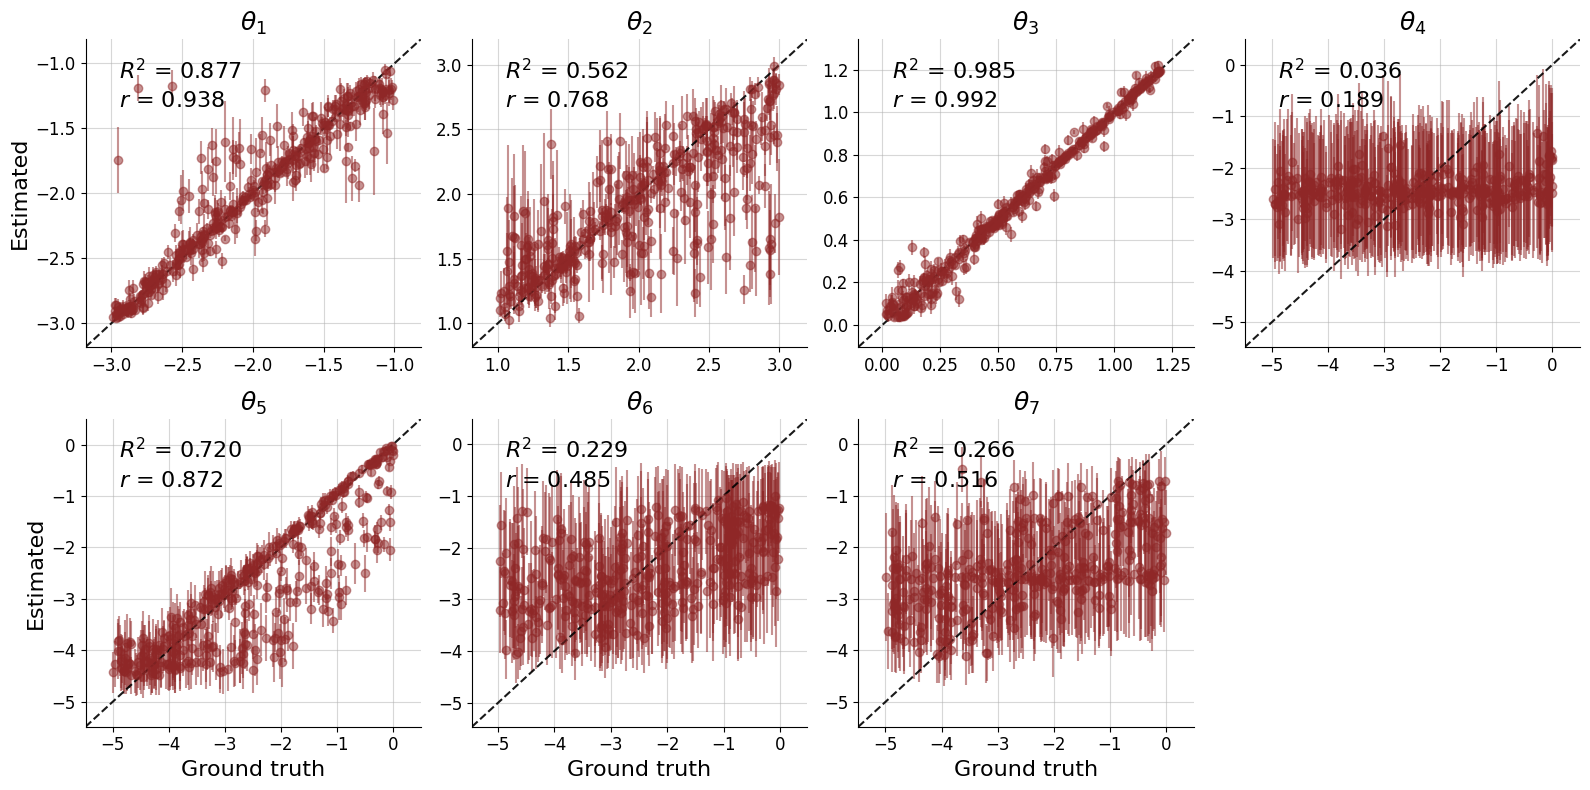

In [15]:
f = bf.diagnostics.plot_recovery(samples, conf['parameters'])

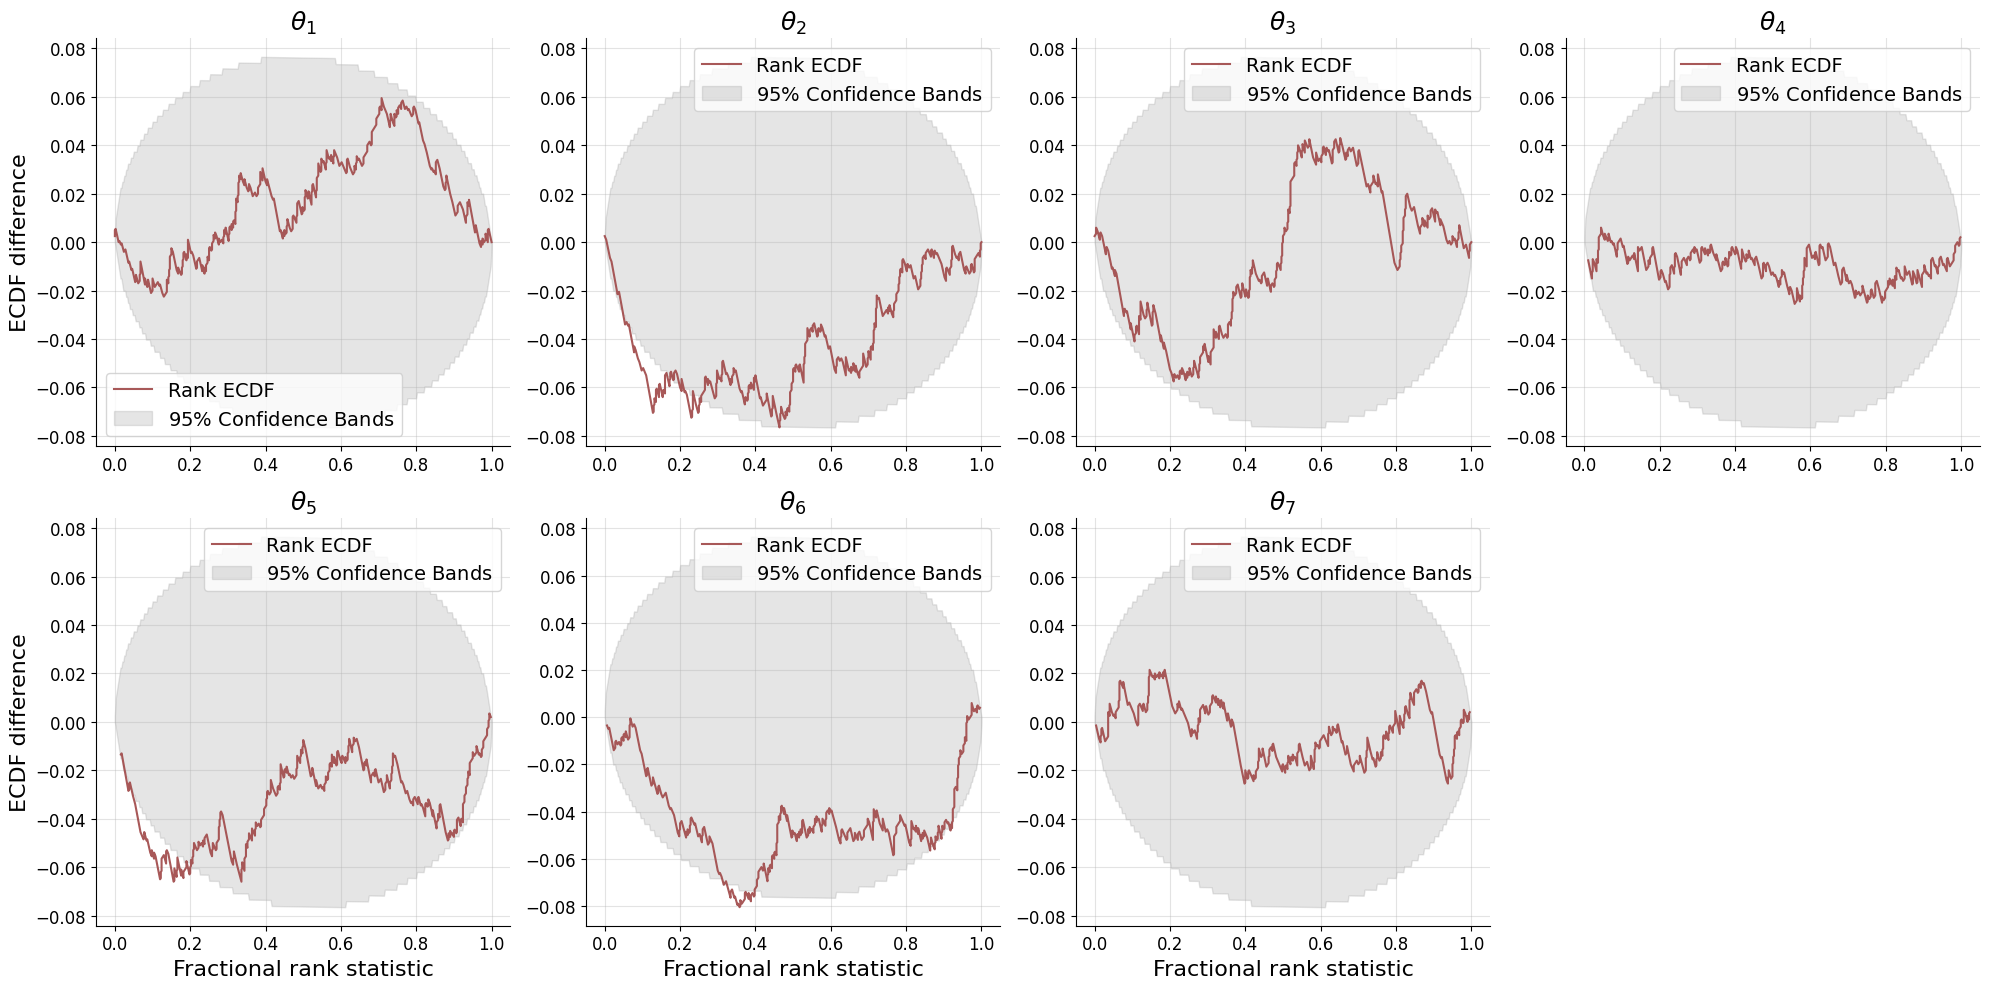

In [20]:
f = bf.diagnostics.plot_sbc_ecdf(samples, conf['parameters'], difference=True)